In [199]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import platform
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
from skimage import morphology, feature, transform, filters

In [303]:
from shapes import *
from detect_bubbles import *
from utils import *

In [304]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
platform.system()

'Windows'

In [6]:
plat = platform.system()
if plat == "Darwin":
    calib_dir =  "/Users/Habib/Google Drive/Uni Heidelberg/11 WS 2017-2018/Masterarbeit/Messungen/Reihe_32_calib_radius" 
elif plat == "Windows":
    calib_dir = "../Messungen/Reihe_32_calib_radius/"

In [7]:
cim = []
bgim = []
filenames = []
for file in os.listdir(calib_dir):
    filenames.append(file)

filenames.sort() # sort after creation date since date is in the name

In [212]:
cim = []
bgim = []
for file in filenames[1:]:
    if int(file[-5:-4])%2 ==0:
        img = cv2.imread(os.path.join(calib_dir, file), 0)
        cim.append(img)
    else:
        img = cv2.imread(os.path.join(calib_dir, file), 0)
        bgim.append(img)

In [128]:
for idx, im in enumerate(cim):
    cv2.imwrite(os.path.join(calib_dir, "redlit", str(idx)+".bmp"), im)
for idx, im in enumerate(bgim):
    cv2.imwrite(os.path.join(calib_dir, "greenlit", str(idx)+".bmp"), im)

In [76]:
track_dir = "data/tracking_data/"
red_tracks = [np.loadtxt(os.path.join(track_dir, file)) for file in os.listdir(track_dir) if file.startswith("red")]
green_tracks = [np.loadtxt(os.path.join(track_dir, file)) for file in os.listdir(track_dir) if file.startswith("green")]

In [77]:
red_tracks[0].T

array([[  0.        ,   1.        ,   2.        ,   3.        ,
          4.        ,   5.        ,   6.        ,   7.        ,
          8.        ,   9.        ,  10.        ,  11.        ,  12.        ],
       [  0.27324533,   0.27324533,   0.32679194,   0.37797624,
          0.43574923,   0.49780005,   0.56459671,   0.63574958,
          0.70964873,   0.78301591,   0.85510844,   0.92646062,
          0.99733114],
       [  0.15512778,   0.15512778,   0.22048618,   0.28899437,
          0.35803697,   0.42713082,   0.49578801,   0.56197411,
          0.62439066,   0.68408263,   0.74258208,   0.80154854,
          0.86454457]])

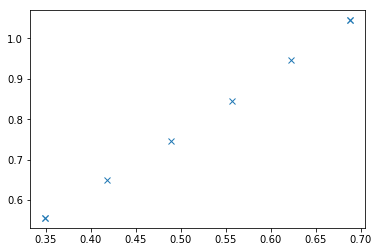

In [78]:
curr_tr = red_tracks[1].T
plt.plot(curr_tr[1] , curr_tr[2], 'x')

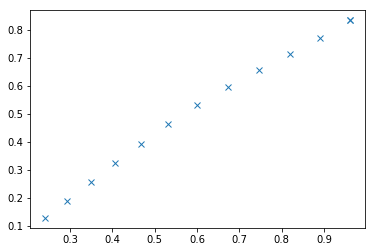

In [80]:
curr_tr = green_tracks[1].T
plt.plot(curr_tr[1] , curr_tr[2], 'x')

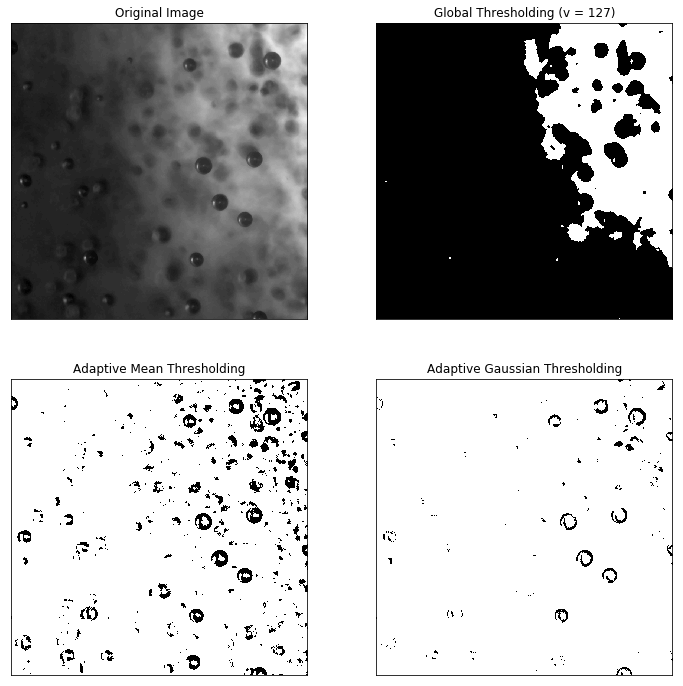

In [90]:
import cv2 as cv
img = bgim[0]
img = cv.medianBlur(img,5)
ret,th1 = cv.threshold(img,60,255,cv.THRESH_BINARY)
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,21,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,31,3)
titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th1, th2, th3]
plt.figure(figsize=(12,12))
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])

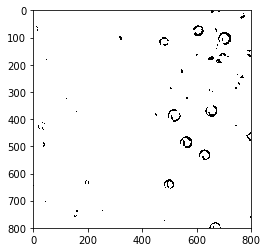

In [108]:
plt.imshow(morphology.closing(th3), cmap="gray")

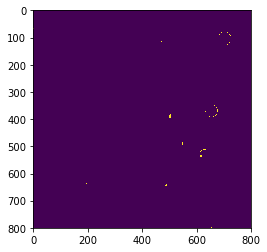

In [106]:
plt.imshow(feature.canny(img, sigma=0.2))

In [136]:
p = Point(0.2679566740989685*800, 0.20746062695980072*800)

In [138]:
a = ll_to_ul(p, 800)

In [141]:
p.get_coord()

(214.3653392791748, 165.96850156784058)

In [142]:
a.get_coord()

(214.3653392791748, 634.0314984321594)

In [215]:
img = bgim[0]
window_size = 30

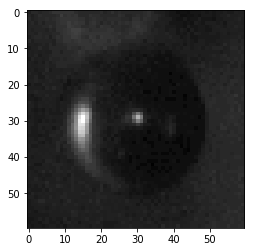

In [216]:
green_bubble = img[int(a.y-window_size):int(a.y+window_size), int(a.x-window_size):int(a.x+window_size)]
plt.imshow(green_bubble, cmap="gray")

In [170]:
from skimage.filters import try_all_threshold

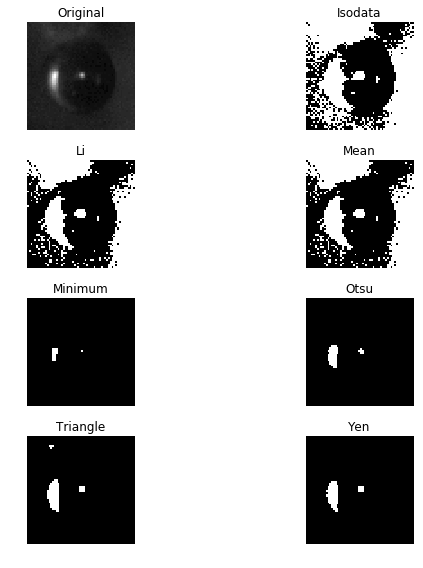

In [171]:
fig, ax = try_all_threshold(green_bubble, figsize=(10, 8), verbose=False)
plt.show()

In [175]:
vert_signal = green_bubble[:, int(green_bubble.shape[1]/2)]

(30, 50)

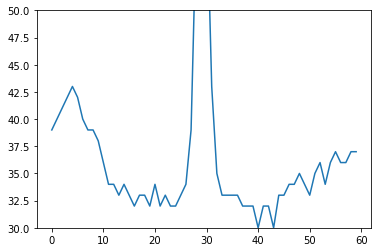

In [179]:
plt.plot(vert_signal)
plt.ylim(30,50)

In [230]:
from skimage.draw import circle_perimeter

In [228]:
edges = filters.sobel(green_bubble)
# Detect two radii
hough_radii = np.arange(10, 35, 1)
hough_res = transform.hough_circle(edges, hough_radii)

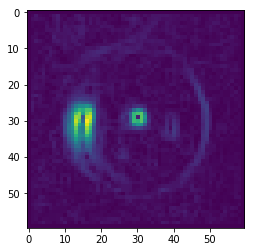

In [229]:
plt.imshow(edges)

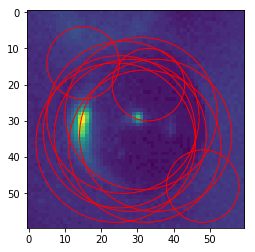

In [255]:
accums, cx, cy, radii = transform.hough_circle_peaks(hough_res, hough_radii,
                                           total_num_peaks=10)

res_circles = []
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
for center_y, center_x, radius in zip(cy, cx, radii):
    res_circles.append(Circle(center_x, center_y, radius))
    ax.add_patch(patches.Circle((center_y, center_x), radius, color="red", fill=False))
plt.imshow(green_bubble)

In [281]:
avg_x = np.mean([circ.x for circ in res_circles])
avg_y = np.mean([circ.y for circ in res_circles])
avg_r = np.mean([circ.radius for circ in res_circles])

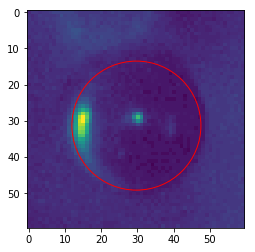

In [282]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.add_patch(patches.Circle((avg_y, avg_x), avg_r, fill=False, color='r'))
plt.imshow(green_bubble)
            

In [315]:
a.get_coord()

(214.3653392791748, 634.0314984321594)

In [313]:
subimg = extract_pad_image(bgim[0], Point(a.y, a.x), window_size=60, pad_mode="constant")

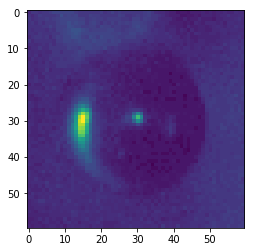

In [314]:
plt.imshow(subimg)

In [341]:
c = green_bubble_one(subimg, hough_radii=np.arange(20,50,1))

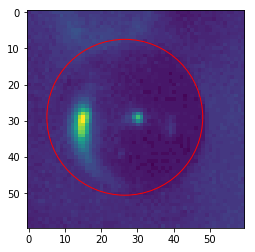

In [342]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 4))
ax.add_patch(patches.Circle((c.y, c.x), c.radius, fill=False, color='r'))
plt.imshow(subimg)

In [331]:
frames, x_arr, y_arr = np.loadtxt("data/tracking_data/greenlit_green_bubble.csv").T

In [335]:
y_arr

array([ 0.20746063,  0.20746063,  0.30195469,  0.39691159,  0.48988128,
        0.58122551,  0.66991621,  0.76052147,  0.85197794,  0.94325352])

(800, 800)